In [55]:
import os
import numpy as np
import scipy.io
import tensorflow as tf

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
#@title Default title text
import tensorflow.compat.v1 as tf

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from functools import reduce
from scipy import signal
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy import signal
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
import os
from tensorflow.keras.models import Sequential, Model, load_model
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras as K

def get_data(path,file):
    mat = loadmat(os.path.join(path,file))
    data = pd.DataFrame(mat['emg'])
    data['stimulus'] = mat['restimulus'] 
    data['repetition'] = mat['repetition']
    
    return data

def normalise(data, train_reps):
    x = [np.where(data.values[:,13] == rep) for rep in train_reps]
    indices = np.squeeze(np.concatenate(x, axis = -1))
    train_data = data.iloc[indices, :]
    train_data = data.reset_index(drop=True)
    
    scaler = StandardScaler(with_mean=True,
                                with_std=True,
                                copy=False).fit(train_data.iloc[:, :12])
    
    scaled = scaler.transform(data.iloc[:,:12])
    normalised = pd.DataFrame(scaled)
    normalised['stimulus'] = data['stimulus']
    normalised['repetition'] = data['repetition']
    return normalised

def filter_data(data, f, butterworth_order = 4, btype = 'lowpass'):
    emg_data = data.values[:,:12]
    
    f_sampling = 2000
    nyquist = f_sampling/2
    if isinstance(f, int):
        fc = f/nyquist
    else:
        fc = list(f)
        for i in range(len(f)):
            fc[i] = fc[i]/nyquist
            
    b,a = signal.butter(butterworth_order, fc, btype=btype)
    transpose = emg_data.T.copy()
    
    for i in range(len(transpose)):
        transpose[i] = (signal.lfilter(b, a, transpose[i]))
    
    filtered = pd.DataFrame(transpose.T)
    filtered['stimulus'] = data['stimulus']
    filtered['repetition'] = data['repetition']
    
    return filtered

def rectify(data):
    return abs(data)



In [59]:
data1 = get_data('/content/drive/My Drive/SOPENI/DB2combined/', 'S1_E1_A1.mat')


In [60]:
data1


,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
0,-0.000003,3.355261e-06,1.598866e-06,-1.394234e-06,-0.000002,2.749975e-06,-2.347791e-06,1.537436e-07,-2.484787e-07,1.469924e-06,-5.609089e-06,0.000040,0,0
1,-0.000005,3.355212e-06,1.430441e-06,-3.072682e-06,-0.000003,2.246543e-06,-1.657156e-07,2.503453e-06,-3.561109e-07,2.478162e-06,-3.259393e-06,0.000050,0,0
2,-0.000003,4.026560e-06,9.263165e-07,-5.422526e-06,-0.000004,1.239568e-06,2.352061e-06,5.524560e-06,-2.445606e-07,2.479306e-06,-7.045269e-08,0.000047,0,0
3,0.000002,2.851566e-06,7.578904e-07,-6.597427e-06,-0.000004,1.575385e-06,2.016400e-06,5.188681e-06,1.094450e-06,2.816148e-06,1.439995e-06,0.000032,0,0
4,0.000004,6.694763e-07,1.764409e-06,-5.422437e-06,-0.000006,7.362596e-07,8.414949e-07,8.244234e-07,1.154750e-06,2.817293e-06,9.700835e-08,0.000014,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808326,-0.000077,-3.075891e-05,-1.203220e-05,-3.283249e-06,-0.000004,2.854926e-07,-2.805851e-07,-8.906829e-06,-4.269690e-06,-2.373901e-06,-3.945436e-06,0.000126,0,6
1808327,-0.000032,-2.370903e-05,-1.136081e-05,-2.275687e-06,-0.000001,2.131741e-06,-3.637238e-06,-3.032428e-06,-1.286812e-06,3.116866e-07,-3.274191e-06,0.000191,0,6
1808328,0.000047,-9.441634e-06,-6.493177e-06,-5.967306e-07,-0.000001,7.888525e-07,-2.965508e-06,5.191863e-06,1.435965e-06,5.347164e-06,-1.931549e-06,0.000167,0,6
1808329,0.000095,2.475874e-06,-1.625549e-06,2.429787e-07,-0.000004,-2.736076e-06,-3.300879e-06,6.702186e-06,2.129538e-06,6.857807e-06,-1.260306e-06,0.000085,0,6


In [61]:
data1.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
count,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06
mean,4.808046e-09,-7.357037e-10,-4.197198e-07,2.112359e-09,-1.398382e-10,8.477333e-10,2.029871e-09,2.024931e-08,9.771852e-09,-4.893191e-07,2.336826e-09,7.045633e-09,3.386753e+00,2.180416e+00
std,4.108262e-05,2.755114e-05,4.318822e-05,4.572169e-05,1.158778e-05,1.032079e-05,4.755128e-05,7.477344e-05,4.726448e-05,5.233670e-05,7.772832e-06,3.710759e-05,5.210184e+00,2.165587e+00
min,-1.414742e-03,-1.417531e-03,-5.499916e-03,-1.693960e-03,-3.886087e-04,-2.764023e-04,-1.990281e-03,-1.453127e-03,-1.497044e-03,-1.662379e-03,-1.226652e-04,-4.916440e-04,0.000000e+00,0.000000e+00
25%,-4.978786e-06,-3.936091e-06,-3.251690e-06,-2.873654e-06,-2.693712e-06,-2.851705e-06,-5.523253e-06,-5.870371e-06,-3.371552e-06,-8.236710e-06,-2.273728e-06,-7.771074e-06,0.000000e+00,0.000000e+00
50%,1.466555e-07,3.258234e-07,6.282035e-09,8.234291e-08,7.752094e-08,1.029062e-07,1.287111e-06,8.321901e-07,-1.532981e-07,-9.468358e-07,-6.239010e-08,-7.593062e-07,0.000000e+00,2.000000e+00
75%,5.056879e-06,4.663832e-06,3.371931e-06,3.101591e-06,2.885123e-06,3.037450e-06,8.765568e-06,1.014123e-05,2.954850e-06,6.279086e-06,2.107727e-06,4.587339e-06,6.000000e+00,4.000000e+00
max,1.247256e-03,5.895796e-04,5.498070e-03,2.179232e-03,3.563007e-04,3.291671e-04,1.541105e-03,1.005659e-03,1.201373e-03,2.007309e-03,2.103748e-04,8.960569e-04,1.700000e+01,6.000000e+00


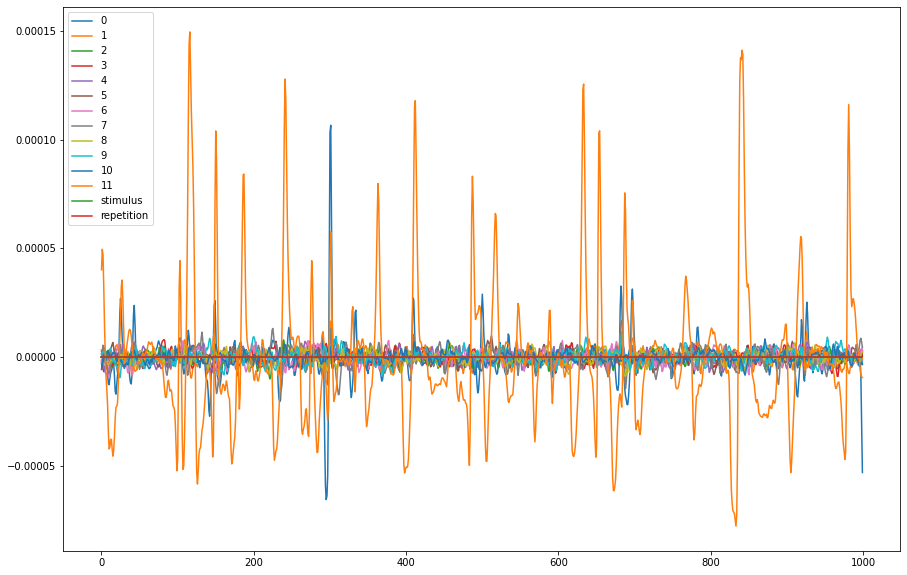

In [62]:
data1[:1000].plot(figsize = (15,10))


In [63]:
train_reps = [1,3,4,6]
test_reps = [2,5]

In [64]:
data1 = normalise(data1, train_reps)


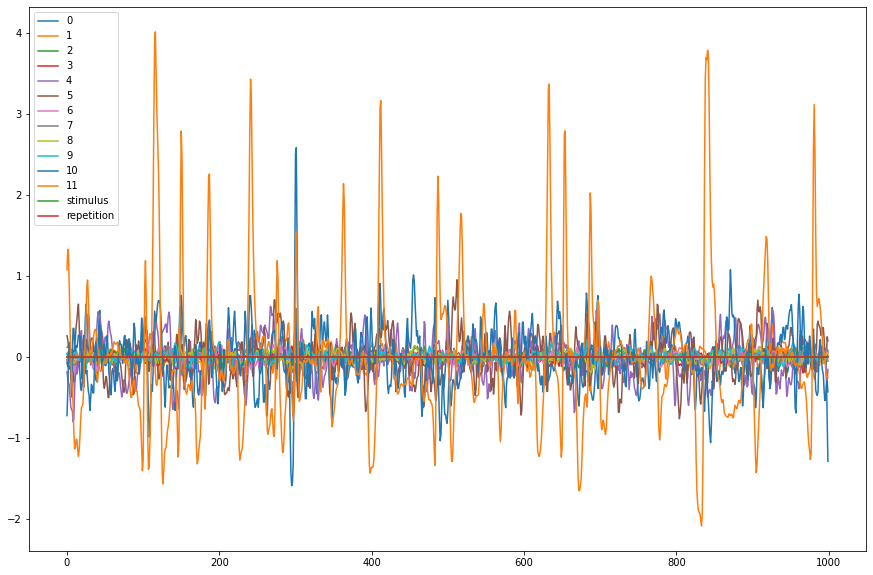

In [65]:
data1[:1000].plot(figsize=(15,10))


In [66]:
emg_low = filter_data(data=data1, f=20, butterworth_order=4, btype='lowpass') 
emg_band = filter_data(data=data1, f=(20,40), butterworth_order=4, btype='bandpass') 
emg_high = filter_data(data=data1, f=20, butterworth_order=4, btype='high')

In [67]:
emg_low.head()


,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
0,-6.235300e-08,1.092388e-07,4.194083e-08,-2.741651e-08,-1.612857e-07,2.390335e-07,-4.432692e-08,1.602173e-09,-4.904495e-09,3.358186e-08,-6.478103e-07,9.709659e-07,0,0
1,-5.912539e-07,9.652132e-07,3.670824e-07,-2.752030e-07,-1.501094e-06,2.068286e-06,-3.505023e-07,4.235716e-08,-4.537932e-08,3.140048e-07,-5.452679e-06,8.806457e-06,0,0
2,-2.767188e-06,4.322773e-06,1.609894e-06,-1.416766e-06,-7.070685e-06,8.936871e-06,-1.334033e-06,3.485151e-07,-2.090416e-07,1.474895e-06,-2.274054e-05,4.017514e-05,0,0
3,-8.623201e-06,1.334822e-05,4.831623e-06,-5.039513e-06,-2.292369e-05,2.640171e-05,-3.319660e-06,1.620160e-06,-6.286767e-07,4.742232e-06,-6.413275e-05,1.253068e-04,0,0
4,-2.037964e-05,3.238002e-05,1.141360e-05,-1.399095e-05,-5.854890e-05,6.131688e-05,-6.192746e-06,5.213826e-06,-1.371138e-06,1.195443e-05,-1.407028e-04,3.051472e-04,0,0


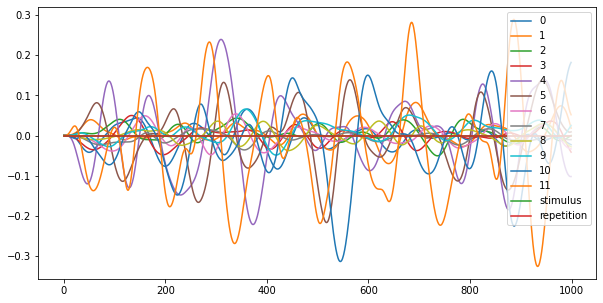

In [68]:
emg_low[:1000].plot(figsize = (10,5))


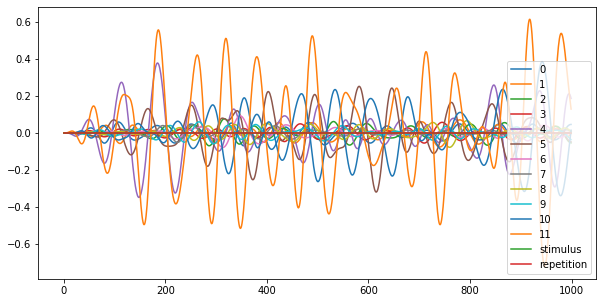

In [69]:
emg_band[:1000].plot(figsize = (10,5))


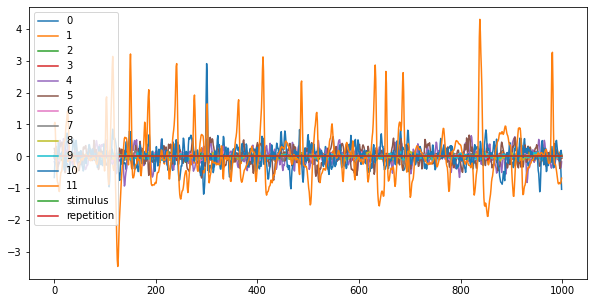

In [70]:
emg_high[:1000].plot(figsize = (10,5))


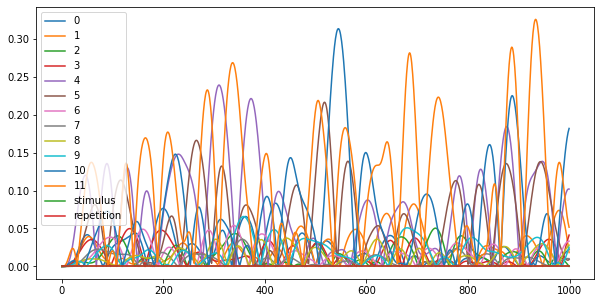

In [71]:
emg_rectified = rectify(emg_low)
emg_rectified[:1000].plot(figsize = (10,5))

In [72]:
X = emg_rectified.drop('stimulus', 1)
X = X.drop('repetition', 1)


In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test= train_test_split(X, test_size=0.2, random_state=0)

In [74]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [75]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [76]:
explained_variance = pca.explained_variance_ratio_


In [77]:
explained_variance

array([0.32195202, 0.12218377, 0.08689767, 0.06957309, 0.06855169,
       0.06157725, 0.05621653, 0.05236894, 0.04559111, 0.04326284,
       0.0416148 , 0.03021031])